In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from pathlib import Path
import cv2
import json
import pandas as pd
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import datetime
import time

from sklearn.metrics import accuracy_score
import lightgbm as lgb

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype_float = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [3]:
letters = ['A', 'I', 'U', 'E', 'O', 'N']

In [4]:
workdir = Path('/home/jphacks/LipNet-JP/')
youtube_id = '1'
# youtube_id = '2'
spk = 's{}'.format(youtube_id)
txtpath = workdir / 'data/align' / 'output{}word.align'.format(youtube_id)
aligned_lm_path = Path('/home/jphacks/LipNet-JP/data/processed2/{0}/{0}_aligned.csv'.format(youtube_id))
lm_path = Path('/home/jphacks/LipNet-JP/data/processed/{0}/{0}.csv'.format(youtube_id))
croppeddir = Path('/home/jphacks/LipNet-JP/data/processed2/{0}/{0}_aligned_aligned_cropped'.format(youtube_id))
assert croppeddir.exists()

datadir = Path('/home/jphacks/LipNet-JP/data')
videodir = datadir / 'lip_video'
txtdir = datadir / 'align_txt'

In [5]:
inwidth, inheight = 160, 80

## Load Data

In [6]:
aligned_lm_df = pd.read_csv(str(aligned_lm_path))
aligned_lm_df['timestamp'] = (aligned_lm_df['frame'] - 1) * (1/30)

with open(txtpath, 'r') as f:
    txt = json.load(f)

aligned_lm_df['target'] = -1

for word in txt:
    for c in word:
        aligned_lm_df.loc[(aligned_lm_df.timestamp >= c['start']) & (aligned_lm_df.timestamp < c['end']), 'target']         = letters.index(c['word'].upper())

In [7]:
## 話していないときのデータを削除
aligned_lm_df = aligned_lm_df[aligned_lm_df['target'] != -1]

## Preprocess Data

In [22]:
all_df = aligned_lm_df.copy()

## Split

In [8]:
train_df, test_df = train_test_split(aligned_lm_df, test_size=.2, shuffle=True)

In [9]:
train_x = train_df[(set(train_df.columns) - {'target'})].values
train_y = train_df.target.values

test_x = test_df[(set(test_df.columns) - {'target'})].values
test_y = test_df.target.values

## Data -> Train Test Dataset

In [10]:
train_x = np.array(train_x, dtype="float32")
train_y = np.array(train_y, dtype="int32")

test_x = np.array(test_x, dtype="float32")
test_y = np.array(test_y, dtype="int32")

train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)

In [11]:
EPOCH_NUM = 100
HIDDEN_SIZE = 20
BATCH_SIZE = 20
N = 100

In [12]:
train = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

# ResNet

### Util

In [49]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Data Import

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype_float = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [51]:
letters = ['A', 'I', 'U', 'E', 'O', 'N']

In [52]:
workdir = Path('/home/jphacks/LipNet-JP/')
youtube_id = '1'
# youtube_id = '2'
spk = 's{}'.format(youtube_id)
txtpath = workdir / 'data/align' / 'output{}word.align'.format(youtube_id)
aligned_lm_path = Path('/home/jphacks/LipNet-JP/data/processed2/{0}/{0}_aligned.csv'.format(youtube_id))
lm_path = Path('/home/jphacks/LipNet-JP/data/processed/{0}/{0}.csv'.format(youtube_id))
croppeddir = Path('/home/jphacks/LipNet-JP/data/processed2/{0}/{0}_aligned_aligned_cropped'.format(youtube_id))
assert croppeddir.exists()

datadir = Path('/home/jphacks/LipNet-JP/data')
videodir = datadir / 'lip_video'
txtdir = datadir / 'align_txt'

In [53]:
preprocess = transforms.Compose([
    transforms.Resize(152),
    transforms.CenterCrop(152),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Load

In [54]:
inwidth, inheight = 160, 80

In [55]:
aligned_lm_df = pd.read_csv(str(aligned_lm_path))
aligned_lm_df['timestamp'] = (aligned_lm_df['frame'] - 1) * (1/30)

with open(txtpath, 'r') as f:
    txt = json.load(f)

aligned_lm_df['target'] = -1

for word in txt:
#     print("".join([c["word"] for c in word]))
    for c in word:
        aligned_lm_df.loc[(aligned_lm_df.timestamp >= c['start']) & (aligned_lm_df.timestamp < c['end']), 'target'] = letters.index(c['word'].upper())

In [57]:
imglist = []
targetlist = []
_lett_counter = {l: 0 for l in letters}
for idx, row in aligned_lm_df.iterrows():
    if row.target < 0:
        continue
    imgpath = croppeddir / 'frame_det_00_{:06d}.bmp'.format(int(row.frame))
    img = Image.open(str(imgpath))
    input_tensor = preprocess(img)
    size = np.asarray(img).shape
    if size != (inheight, inwidth, 3):
        continue
    # img = np.moveaxis(img, 2, 0)  # (80, 160, 3) -> (3, 80, 160)
    imglist.append(input_tensor)
    targetlist.append(int(row.target))
    _lett_counter[letters[int(row.target)]] += 1

## Dataset

In [58]:
class LipDataset(Dataset):
    def __init__(self, imglist, targetlist, idxlist):
        self.imglist = imglist
        self.targetlist = targetlist
        self.idxlist = idxlist
    
    def __len__(self):
        return len(self.idxlist)
    
    def __getitem__(self, idx):
        return (self.imglist[self.idxlist[idx]], self.targetlist[self.idxlist[idx]])
    
    def _to_list(self):
        return [self[i] for i in range(len(self))]

In [59]:
train_idxlist, test_idxlist = train_test_split(list(range(len(imglist))), test_size=.2, shuffle=True)
train_idxlist, validate_idxlist = train_test_split(train_idxlist, test_size=.2, shuffle=True)

print(len(train_idxlist), len(validate_idxlist), len(test_idxlist))

3196 799 999


In [60]:
train_lipdataset = LipDataset(imglist, targetlist, train_idxlist)
validate_lipdataset = LipDataset(imglist, targetlist, validate_idxlist)
test_lipdataset = LipDataset(imglist, targetlist, test_idxlist)

In [61]:
BATCH_SIZE = 18

In [62]:
trainloader = torch.utils.data.DataLoader(train_lipdataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
validateloader = torch.utils.data.DataLoader(validate_lipdataset, batch_size=1,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_lipdataset, batch_size=1,
                                         shuffle=False, num_workers=2)

## Model

In [63]:
# net = torchvision.models.resnet34(pretrained=True, num_classes=6).to(device)
net = torchvision.models.resnet34(pretrained=False).to(device)

In [64]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Train

In [71]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch_idx, (data, target) in enumerate(iterator):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = net(data)
        
        loss = criterion(output, target)
        _, predicted = torch.max(output, 1)
        acc = (predicted == target.to(device)).sum()
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item() / BATCH_SIZE
        epoch_acc += acc.item() / BATCH_SIZE
        
        break

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [66]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch_idx, (data, target) in enumerate(iterator):
            
            data, target = data.to(device), target.to(device)
                        
            output = model(data.type(dtype_float))
            
            loss = criterion(output, target)
            
            _, predicted = torch.max(output.data, 1)
            
            acc = (predicted == target.to(device)).sum()
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(net, trainloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(net, validateloader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(train_loss, train_acc)
    print(valid_loss, valid_acc)
#     print(f'\tTrain Loss: {float(train_loss):.3f} | Train Acc: {float(train_acc*100):.2f}%')
#     print(f'\t Val. Loss: {float(valid_loss):.3f} |  Val. Acc: {float(valid_acc*100):.2f}%')

Epoch: 01 | Epoch Time: 0m 15s
0.00041985158319032747 0.0028089887640449437
1.5994130261102517 0.3541927409261577
Epoch: 02 | Epoch Time: 0m 15s
0.0004141763801431834 0.0024968789013732834
1.6137177419006004 0.3591989987484355
Epoch: 03 | Epoch Time: 0m 15s
0.00039636344647734945 0.0031210986267166045
1.621929926030776 0.3541927409261577


## Test

In [ ]:
def test(model, iterator, optimizer, criterion):
    model.eval()
    class_correct = [0.] * len(letters)
    class_total = [0.] * len(letters)
    with torch.no_grad():
        for data in iterator:
            images, labels = data
            outputs = net(images.type(dtype_float))
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels.to(device)).squeeze()
            class_correct[labels.item()] += c.item() * 1
            class_total[labels.item()] += 1

    for i, l in enumerate(letters):
        print('Accuracy of    {}: {:.4f} ({:4d}/{:4d})'.format(l, class_correct[i]/class_total[i] if class_total[i] > 0 else 0, int(class_correct[i]), int(class_total[i])))

In [ ]:
test(net, testloader, optimizer, criterion)

## Load

In [ ]:
dtype_float = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(152),
    transforms.CenterCrop(152),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
model = torchvision.models.resnet34(pretrained=True).to(device)
model.load_state_dict(torch.load("tut5-model.pt"))

img = Image.open(str(list(croppeddir.iterdir())[0]))
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)

outputs = model(input_batch.type(dtype_float))
_, predicted = torch.max(outputs, 1)
predict_label = predicted.squeeze().item()

# Bagging using ResNet

# LGBM

In [13]:
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [23]:
train_df, test_df = train_test_split(all_df, test_size=.2, shuffle=True)

In [24]:
train_x = train_df[(set(train_df.columns) - {'target'})].values
train_y = train_df.target.values

test_x = test_df[(set(test_df.columns) - {'target'})].values
test_y = test_df.target.values

In [25]:
model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
model.fit(train_x, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [26]:
accuracy_score(model.predict(train_x), train_y)

0.9994998749687422

In [27]:
accuracy_score(model.predict(test_x), test_y)

0.658

In [28]:
pred = model.predict(test_x)

class_correct = [0] * len(letters)
class_total = [0] * len(letters)

for p, a in zip(pred, test_y):
    class_total[a] += 1
    if p == a:
        class_correct[a] += 1

for i, l in enumerate(letters):
    print('Accuracy of    {}: {:.4f} ({:4d}/{:4d})'.format(l, class_correct[i]/class_total[i], class_correct[i], class_total[i]))

Accuracy of    A: 0.7311 ( 193/ 264)
Accuracy of    I: 0.6452 ( 120/ 186)
Accuracy of    U: 0.5978 (  55/  92)
Accuracy of    E: 0.5338 (  71/ 133)
Accuracy of    O: 0.7339 ( 160/ 218)
Accuracy of    N: 0.5514 (  59/ 107)


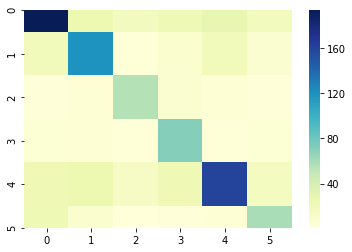

In [31]:
confusion_matrix = np.zeros([len(letters), len(letters)])
for p, a in zip(pred, test_y):
    confusion_matrix[p, a] += 1
    
sns.heatmap(confusion_matrix, cmap="YlGnBu")